In [1]:
%matplotlib inline
#
from LRGSG_package.shared import *
from LRGSG_package.config.utils import *
from lrgsglib.core import gaussian_filter, Lattice2D, \
    read_files_to_2d_array, move_to_rootf, eigV_for_lattice2D, \
    create_symmetric_log_bins, bin_eigenvalues
#
move_to_rootf(True)

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


### Smallest eigenvalue Signed Laplacian

In [2]:
geo = 'squared'
#
nAvg = 500
bins_count = 500
period = 20
workDir = "data/plot/dev_tool_Lattice2D/"
os.makedirs(workDir, exist_ok=True)
for mode in ['scipy', 'numpy']:
    for side in [16, 32]:
        for pflip in [0.01, 0.05, 0.103, 0.2]:
            #
            fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
            fname = f"{workDir}{fnameBase}_{nAvg}.pkl"

            # Setup and initial calculation
            initial_eig = np.abs(eigV_for_lattice2D(side, pflip=pflip, geo=geo, mode=mode))
            bins, bin_centers = create_symmetric_log_bins(np.min(initial_eig), np.max(initial_eig), bins_count)

            bin_counter = Counter()
            fnameOld = ""
            if not os.path.exists(fname):
                print(mode, side, pflip)
                nAvgDone = 0
                fnameExists = glob.glob(f"{workDir}{fnameBase}*")
                if fnameExists:
                    nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
                    fnameOld = fnameExists[0]
                nAvgNeed = nAvg - nAvgDone
                for current_period in range((nAvgNeed // period) + bool(nAvgNeed % period)):
                    batch_size = min(nAvgNeed - current_period * period, period)
                    eig_values = np.concatenate([eigV_for_lattice2D(side, pflip=pflip, geo=geo, mode=mode) for _ in range(batch_size)])
                    bin_counter.update(bin_eigenvalues(eig_values, bins, bin_centers))
                    fnameNew = f"{workDir}{fnameBase}_{nAvgDone + (current_period + 1) * period}.pkl"
                    try:
                        os.rename(fnameOld, fnameNew)
                    except FileNotFoundError:
                        pass
                    with open(fnameNew, "wb") as f:
                        pk.dump(dict(bin_counter), f)
                    fnameOld = fnameNew

                # At the end, save the final state if needed
                if nAvgNeed % period:
                    fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
                    os.rename(fnameOld, fnameNew)
                    with open(fnameNew, "wb") as f:
                        pk.dump(dict(bin_counter), f)


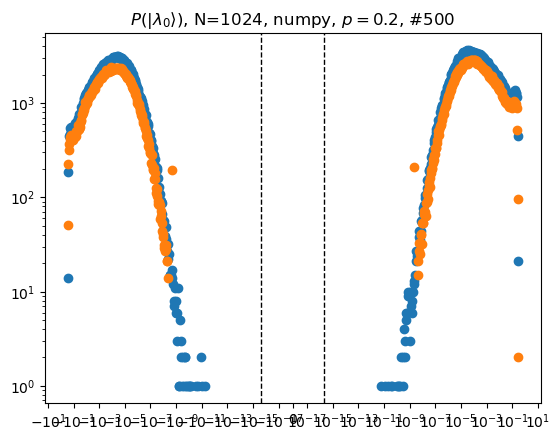

In [7]:
plt.axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)

pflip = 0.2
for side in [32]:
    for mode in ['scipy', 'numpy']:
        fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
        fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
        with open(fname, "rb") as f:
            k, v = zip(*sorted(pk.load(f).items()))
        plt.plot(k, v, 'o')

plt.title(fr"$P(|\lambda_0\rangle)$, N={side**2}, {mode}, $p={pflip}$, #{nAvg}")
plt.xscale('symlog', linthresh=1e-17)
plt.yscale('log')
plt.savefig(f"{workDir}dist_{pflip:.3g}_{nAvg}.png")

In [ ]:

# Setup and initial calculation
initial_eig = np.abs(eigV_for_lattice2D(side, pflip=pflip, geo=geo, mode=mode))
bins, bin_centers = create_symmetric_log_bins(np.min(initial_eig), np.max(initial_eig), bins_count)

bin_counter = Counter()
fnameOld = ""
if not os.path.exists(fname):
    nAvgDone = 0
    fnameExists = glob.glob(f"{workDir}{fnameBase}*")
    if fnameExists:
        nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
        fnameOld = fnameExists[0]
    nAvgNeed = nAvg - nAvgDone
    for current_period in range((nAvgNeed // period) + bool(nAvgNeed % period)):
        batch_size = min(nAvgNeed - current_period * period, period)
        eig_values = np.concatenate([eigV_for_lattice2D(side, pflip=pflip, geo=geo, mode=mode) for _ in range(batch_size)])
        bin_counter.update(bin_eigenvalues(eig_values, bins, bin_centers))
        fnameNew = f"{workDir}{fnameBase}_{nAvgDone + (current_period + 1) * period}.pkl"
        try:
            os.rename(fnameOld, fnameNew)
        except FileNotFoundError:
            pass
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)
        fnameOld = fnameNew

    # At the end, save the final state if needed
    if nAvgNeed % period:
        fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
        os.rename(fnameOld, fnameNew)
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)


In [ ]:
mode = 'scipy'
fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
with open(fname, "rb") as f:
    k, v = zip(*sorted(pk.load(f).items()))
plt.axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.plot(k, v, 'o')
#
mode = 'numpy'
fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
with open(fname, "rb") as f:
    k, v = zip(*sorted(pk.load(f).items()))
plt.plot(k, v, 'o')

plt.title(fr"$P(|\lambda_0\rangle)$, N={side**2}, {mode}, $p={pflip}$, #{nAvg}")
plt.xscale('symlog', linthresh=1e-17)
plt.yscale('log')
plt.savefig(f"{workDir}dist_{side}_{pflip:.3g}_{nAvg}.png")

In [ ]:
def eigV_for_lattice2D(side, mode='scipy', **kwargs):
    l = Lattice2D(side, **kwargs)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(MODE_dynspec=mode)
    return flip_to_positive_majority(l.eigV[0])
def create_symmetric_log_bins(min_val, max_val, num_bins, incMagn = 2):
    """Creates symmetric logarithmic bins."""
    bins_positive = np.logspace(np.log10(min_val)-incMagn, np.log10(max_val)+incMagn, num_bins//2)
    bins_negative = -np.flip(bins_positive)
    return np.concatenate((bins_negative, [0], bins_positive))
def bin_eigenvalues(eig_values, bins):
    """Bins eigenvalues and counts occurrences in each bin."""
    indices = np.digitize(eig_values, bins, right=True)
    return Counter(indices)

In [ ]:
# Setup
side = 64
geo = 'squared'
pflip = 0.103
#
nAvg = 200
bins_count = 500
period = 20
#
workDir = "data/plot/dev_tool_Lattice2D/"
mode = 'numpy'
fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"

In [ ]:
# Get initial eigenvalues to define bins
initial_eig = np.abs(eigV_for_lattice2D(side, pflip=pflip, geo=geo, mode=mode))
print(np.log10(np.max(initial_eig))+4)
bins = create_symmetric_log_bins(np.min(initial_eig), np.max(initial_eig), 
                                 bins_count)
#
bin_counter = Counter()
fnameOld = ""
if not os.path.exists(fname):
    nAvgDone = 0
    fnameExists = glob.glob(f"{workDir}{fnameBase}*")
    if fnameExists:
        nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
        fnameOld = fnameExists[0]
    nAvgNeed = nAvg - nAvgDone
    for current_period in range((nAvgNeed // period) + bool(nAvgNeed % period)):
        batch_size = min(nAvgNeed - current_period * period, period)
        eig_values = np.concatenate([eigV_for_lattice2D(side, pflip=pflip, geo=geo, mode=mode) for _ in range(batch_size)])
        bin_counter.update(bin_eigenvalues(eig_values, bins))
        fnameNew = f"{workDir}{fnameBase}_{nAvgDone + (current_period + 1) * period}.pkl"
        try:
            os.rename(fnameOld, fnameNew)
        except FileNotFoundError:
            pass
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)
        fnameOld = fnameNew

    # At the end, save the final state if needed
    if nAvgNeed % period:
        fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
        os.rename(fnameOld, fnameNew)
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)

In [ ]:
mode = 'scipy'
fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
k,v = zip(*pk.load(open(fname, "rb")).items())
binsv = bins[np.array(k)-1]
plt.plot(binsv, v, 'o')
#
mode = 'numpy'
fnameBase = f"dist_{side}_{pflip:.3g}_{mode}"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"
k,v = zip(*pk.load(open(fname, "rb")).items())
binsv = bins[np.array(k)-1]
plt.plot(binsv, v, 'o')
#
plt.title(fr"$P(|\lambda_0\rangle)$, N={side**2}, {mode}, $p={pflip}$, #{nAvg}")
plt.axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.xscale('symlog', linthresh=1e-17)
plt.yscale('log')
plt.savefig(f"{workDir}dist_{side}_{pflip:.3g}_{nAvg}_{mode}.png")

In [ ]:
l = Lattice2D(128, pflip=0.103, geo='squared')
l.flip_random_fract_edges()
l.compute_k_eigvV(MODE_dynspec='scipy')
np.max(flip_to_positive_majority(l.eigV[0]))

In [ ]:
l = Lattice2D(64, pflip=0.103, geo='squared')
l.flip_random_fract_edges()
l.compute_k_eigvV(MODE_dynspec='scipy')
#
outp, outm = symlog_binning(flip_to_positive_majority(l.eigV[0].flatten()))
plt.plot(outp[0], outp[1], marker='o', lw=1)
plt.plot(outm[0], outm[1], marker='o', lw=1)
plt.xscale('symlog', linthresh=1e-20)
plt.yscale('log')
plt.axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)

### phtra plot

In [ ]:
perc = pd.read_csv("/home/opisthofulax/PhD/projects/complex-networks/LRG-Signed/data/plot/tmp/OrderP_L64",
                       sep=',', header=None)
l = Lattice2D(64, geo='squared', 
            init_nw_dict=True, 
            with_positions=False,
            sgpath="plot/paper/suppinf/phase_transition_l2d/"
)
data = read_files_to_2d_array(l.phtrapath, 'rand')
data = data[np.argsort(data[:, 0])]
#
pinf2 = gaussian_filter(data[:, 5], sigma=2)
#
chi = gaussian_filter(data[:, 7]*l.N, sigma=1)
#
x_scaled = data[:, 0]
#
chi_scaled = gaussian_filter(perc[3]*64**2,sigma=0)

chiplot, = plt.plot(perc[5], chi_scaled,
                          lw=2, marker='')
chiplot, = plt.plot(x_scaled, chi,
                          lw=2, marker='')

### precision problems

In [ ]:
np.random.seed(0)
random.seed(0)
#
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(35, 7))
#
l = Lattice2D(128, pflip=0.103)
l.flip_random_fract_edges()
l.compute_k_eigvV(howmany=5, MODE_dynspec="scipy", typf=np.float32)
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'red', 'white'])
for i in range(5):
    ei = flip_to_positive_majority(l.eigV[i].reshape(l.syshape))
    result = sign_with_threshold(ei, threshold=1e-7)
    ax[i].imshow(result, cmap=cmap, interpolation=None)

np.random.seed(0)
random.seed(0)
l = Lattice2D(128, pflip=0.103)
l.flip_random_fract_edges()
l.compute_k_eigvV(howmany=5, MODE_dynspec="numpy", typf=np.float64)
for i in range(5,10):
    ei = flip_to_positive_majority(l.eigV[i].reshape(l.syshape))
    result = sign_with_threshold(ei, threshold=1e-15)
    ax[i].imshow(result, cmap=cmap, interpolation=None)

In [ ]:
np.random.seed(0)
random.seed(0)
fig, ax = plt.subplots(ncols=5, figsize=(35,7))


In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(35,35))
for i in range(10):
    l = Lattice2D(128, pflip=0.12)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(howmany=2)
    ei = l.eigV[0].reshape(l.syshape)
    result = sign_with_threshold(ei, threshold=1e-15)
    ax[i//5][i%5].imshow(result, cmap=cmap, interpolation=None)

In [ ]:
k, v = l.cluster_distribution_list().keys(), l.cluster_distribution_list().values()
plt.plot(k, v, marker='o', lw=0)
plt.yscale('log')
plt.xscale('log')

### Distribution of values first eigenstate

In [ ]:
%matplotlib inline
#
from LRGSG_package.shared import *
from LRGSG_package.config.utils import *
from lrgsglib.core import gaussian_filter, Lattice2D, \
    read_files_to_2d_array, move_to_rootf
#
move_to_rootf(True)

In [ ]:
l = Lattice2D(64, pflip=0.1, geo='squared')
l.flip_random_fract_edges()
l.compute_k_eigvV(MODE_dynspec='numpy')

In [ ]:
outp, outm = symlog_binning(flip_to_positive_majority(l.eigV[0].flatten()))
plt.plot(outp[0], outp[1], marker='o', lw=1)
plt.plot(outm[0], outm[1], marker='o', lw=1)
plt.xscale('symlog', linthresh=1e-20)
plt.yscale('log')
plt.axvline(np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)
plt.axvline(-np.finfo(np.float64).eps, color='k', linestyle='--', lw=1)

In [ ]:
def flip_edges_optimized(graph, fraction=0.5):
    """
    Flips the sign of a fraction of the +1 edges in the graph to -1 using more concise NetworkX functions.

    Parameters:
    - graph: A networkx graph where edges have a 'weight' attribute.
    - fraction: Fraction of +1 weighted edges to flip. Value between 0 and 1.

    Returns:
    - The modified graph with some edges flipped.
    """
    # Ensure the fraction is between 0 and 1
    if not (0 <= fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    # Find all edges with weight +1
    
    # Calculate the number of edges to flip
    num_to_flip = int(graph.number_of_edges() * fraction)
    
    # Randomly select a subset of positive edges to flip
    edges_to_flip = random.sample(list(graph.edges()), k=num_to_flip)
    
    # Prepare a dictionary with the selected edges and their new weight
    flipped_edges = {graph[i][j]: -1 for (i, j) in edges_to_flip}
    
    # Use set_edge_attributes to apply the new weights
    nx.set_edge_attributes(graph, flipped_edges, 'weight')
    
    return graph

In [ ]:
G = nx.grid_2d_graph(128, 128, periodic=True)
nx.set_edge_attributes(G, +1, 'weight')
flip_edges_optimized(G, 0.5)

In [ ]:
G[(0, 0)][(0, 1)]

In [ ]:


# plt.xlim(-1.5, 1)

In [ ]:
np.where(np.isnan(l.eigV[0].flatten()))

In [ ]:
np.isnan(np.logl.eigV[0].flatten()).any()